In [13]:
import tempfile
import os

import subprocess
import scanpy as sc 
import datatable as dt 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import umap 

from SURE import SURE

import torch 
torch.set_float32_matmul_precision("high")


codebook_size=500 # number of metacells

## Download and load dataset

In this tutorial, we show how to call metacells by using a dataset including data produced by a variety of commercial single-cell platforms. The dataset could be downloaded from the CellxGene website [here](https://cellxgene.cziscience.com/collections/398e34a9-8736-4b27-a9a7-31a47a67f446). 

In [6]:
adata = sc.read_h5ad('/media/oem/UB20_DATA/Workspace/Tutorial/tutorial_1/7bdecd9b-abfa-49f9-b79a-827e3207b0d3.h5ad')
adata = adata.raw.to_adata()
adata.layers['counts'] = adata.X.copy()

## Visualization of batch effects in this dataset

In [7]:
adata_bk = adata.copy()

sc.pp.normalize_total(adata_bk, target_sum=1e4)
sc.pp.log1p(adata_bk)
sc.pp.highly_variable_genes(adata_bk, n_top_genes=5000, subset=True)
sc.pp.pca(adata_bk)

adata_bk.obsm['X_umap'] = umap.UMAP().fit_transform(adata_bk.obsm['X_pca'])

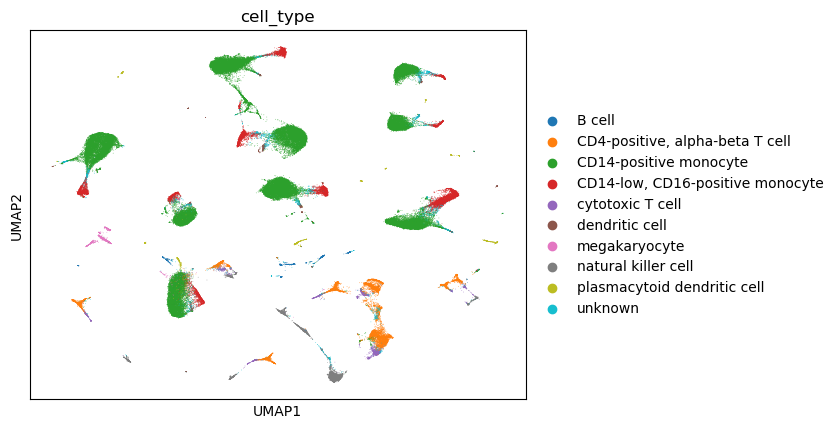

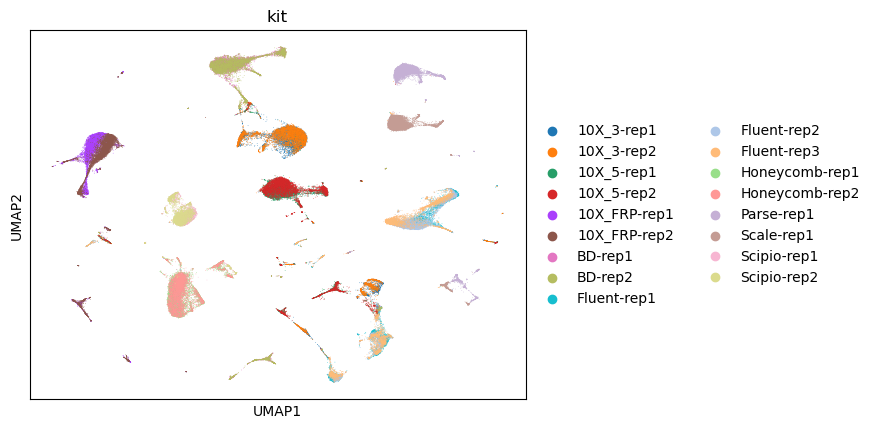

In [10]:
sc.pl.umap(adata_bk, color='cell_type')
sc.pl.umap(adata_bk, color='kit')

## Use SURE to call metacells within this dataset

### Prepare the input files

In [15]:
with tempfile.TemporaryDirectory() as temp_dir:
    # write count data into a local file
    xs = adata[:, adata_bk.var_names].layers['counts'].toarray()
    counts_file = os.path.join(temp_dir, 'temp_counts.txt.gz')
    dt.Frame(pd.DataFrame(xs, columns=adata_bk.var_names, dtype=np.float64)).to_csv(counts_file)

    # write undesired factors into a local file
    enc = OneHotEncoder(sparse_output=False).fit(adata.obs['kit'].to_numpy().reshape(-1,1))
    us = enc.transform(adata.obs['kit'].to_numpy().reshape(-1,1))
    uwv_file = os.path.join(temp_dir, 'temp_uwv.txt.gz')
    pd.DataFrame(us, columns=enc.categories_).to_csv(uwv_file, index=False)

    # call SURE
    model_file = os.path.join(temp_dir, f'temp_sure_{codebook_size}.txt.gz')
    cmd = f'CUDA_VISIBLE_DEVICES=0  SURE --data-file "{counts_file}" \
    --undesired-factor-file "{uwv_file}" \
    --jit \
    --seed 0 \
    --cuda \
    -lr 0.0001 \
    -n 200 \
    -bs 512 \
    -cs {codebook_size} \
    -dirichlet \
    -likeli negbinomial \
    -zi exact \
    --save-model "{model_file}"'

    subprocess.call(cmd, shell=True)

    # load the model
    model = SURE.load_model(model_file)

100%|██████████| 122/122 [00:00<00:00, 254.66batch/s]


Model saved to /tmp/tmp5dhng675/temp_sure_500.txt.gz
Model loaded from /tmp/tmp5dhng675/temp_sure_500.txt.gz


### Get the latent representations of cells

In [16]:
zs = model.get_cell_coordinates(xs)
adata.obsm['X_umap'] = umap.UMAP().fit_transform(zs)

100%|██████████| 122/122 [00:00<00:00, 411.70batch/s]


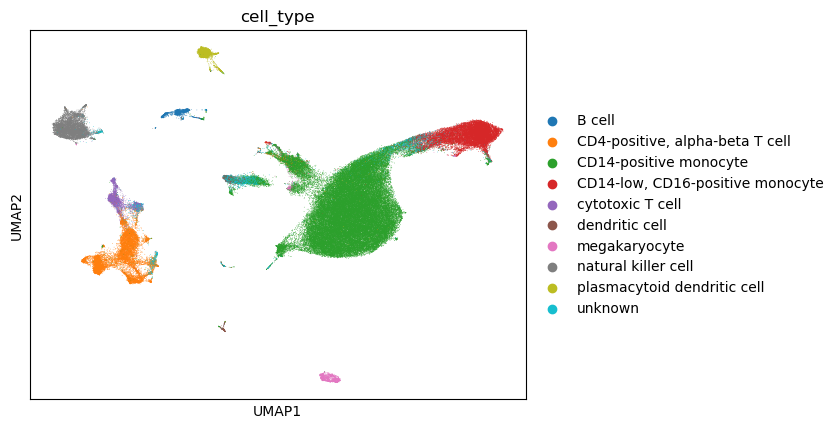

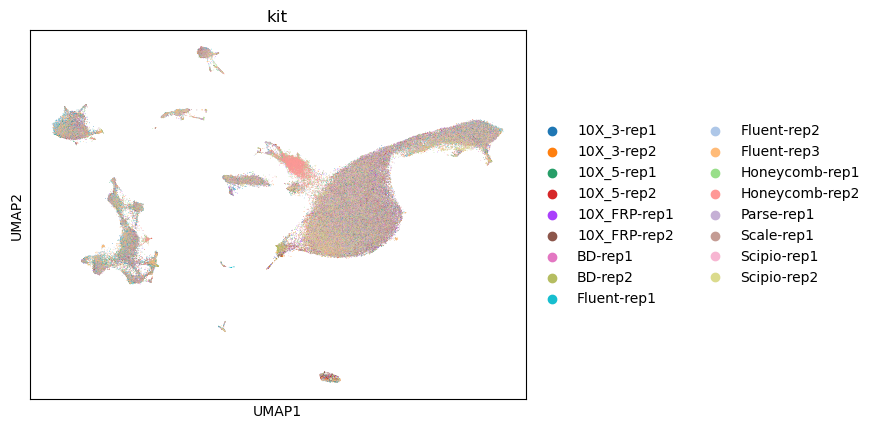

In [17]:
sc.pl.umap(adata, color='cell_type')
sc.pl.umap(adata, color='kit')